# Customer Churn Analysis for a Retail Bank

_Exploratory Data Analysis (EDA) Portfolio Project_

This notebook explores a bank customer dataset to understand **customer churn** — 
which clients are leaving the bank, why they might be leaving, and what actions the bank 
could take to reduce churn.

The analysis is guided by three core business questions:

1. **Who is most likely to churn?** (customer segments and profiles)  
2. **What factors are driving churn?** (behavioural and demographic drivers)  
3. **What can the bank do to reduce churn?** (data-driven recommendations)


## Table of Contents

1. [Introduction](#introduction)  
2. [Data Preparation & Imports](#prep)  
3. [Data Wrangling](#wrangling)  
4. [Exploratory Data Analysis](#eda)  
    - [4.1 Overall Churn Distribution](#overall_churn)
    - [4.2 Numeric Features vs Churn](#numeric_churn)
    - [4.3 Correlation Analysis](#correlation)
    - [4.4 Churn Drivers (Categorical & Model-Based)](#drivers)
5. [Insights, Conclusions & Recommendations](#conclusions)


## 1. Introduction <a id="introduction"></a>

### 1.1 Business Context

Banks operate in a highly competitive environment where **retaining existing customers** 
is often more cost-effective than acquiring new ones. Understanding churn is therefore 
critical for profitability and long-term growth.

In this project, I investigate a dataset of **10,000 bank customers** with the goal of 
understanding which customers are most likely to churn and what might be driving that behaviour.

---

### 1.2 Dataset Description

The dataset contains information about individual bank clients, including:

- Demographic details (e.g., **Geography, Gender, Age**)  
- Relationship characteristics (e.g., **Tenure, Number of products**)  
- Financial attributes (e.g., **CreditScore, Balance, EstimatedSalary**)  
- Behavioural indicators (e.g., **Active membership, Has credit card**)  
- Target variable (**`Exited`**): whether the customer has left the bank (1) or stayed (0)

Each row represents a single customer at a point in time.

---

### 1.3 Guiding Business Questions

This analysis is structured around three main questions:

1. **Who is most likely to churn?**  
   Which segments (by age, geography, tenure, balance, etc.) have the highest churn rates?

2. **What factors are driving churn?**  
   How do features like credit score, balance, activity level, and product usage relate to 
   the likelihood of churn?

3. **What can the bank do to reduce churn?**  
   Based on the patterns we observe, what targeted retention strategies could the bank implement?


## 2. Data Preparation & Imports <a id="prep"></a>

In this section, I import the core Python libraries used for data analysis and load the churn 
dataset into a pandas DataFrame. I also set a few display options and plotting defaults so that 
all charts have a consistent, professional style.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Global plot style (applies to all charts) ---
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 13

sns.set(style="white")   # minimal style, no auto grid

pd.set_option('display.max_columns', None)

# Load dataset (ensure Churn_Modelling.csv is in the same directory as this notebook)
df = pd.read_csv("Churn_Modelling.csv")

# Initial inspection
df_head = df.head()
df_info = df.info()
df_desc = df.describe().T

df_head


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## 3. Data Wrangling <a id="wrangling"></a>

This section focuses on preparing the dataset for analysis by:

- Removing non-informative identifier columns  
- Converting appropriate fields to categorical types  
- Creating useful engineered features such as **age groups**, **tenure groups**, credit score bands, 
  and a **balance flag**.

These steps make it easier to segment customers and interpret churn patterns.


In [2]:
# --- Missing values check ---
df.isna().sum()


RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [3]:
# --- Remove non-informative identifier columns ---
df = df.drop(columns=["RowNumber", "CustomerId", "Surname"], errors="ignore")

# --- Convert selected fields to categorical types ---
cat_cols = ["Geography", "Gender", "HasCrCard", "IsActiveMember", "NumOfProducts"]
df[cat_cols] = df[cat_cols].astype("category")

# --- Feature Engineering ---

# Age groups (chosen to reflect life stages)
df["AgeGroup"] = pd.cut(
    df["Age"],
    bins=[18, 30, 40, 50, 60, 100],
    labels=["18–29", "30–39", "40–49", "50–59", "60+"],
    right=False
)

# Tenure groups
df["TenureGroup"] = pd.cut(
    df["Tenure"],
    bins=[0, 2, 5, 10],
    labels=["0–2 yrs", "3–5 yrs", "6–10 yrs"],
    right=False
)

# Credit score bands
df["CreditScoreBand"] = pd.cut(
    df["CreditScore"],
    bins=[300, 500, 600, 700, 850],
    labels=["Very Low", "Low", "Medium", "High"],
    right=False
)

# Balance indicator
df["HasBalance"] = np.where(df["Balance"] > 0, "Has Balance", "No Balance")

# Quick preview of engineered columns
df[["Age", "AgeGroup", "Tenure", "TenureGroup", "CreditScore", "CreditScoreBand", "HasBalance", "Exited"]].head()


,Age,AgeGroup,Tenure,TenureGroup,CreditScore,CreditScoreBand,HasBalance,Exited
0,42,40–49,2,3–5 yrs,619,Medium,No Balance,1
1,41,40–49,1,0–2 yrs,608,Medium,Has Balance,0
2,42,40–49,8,6–10 yrs,502,Low,Has Balance,1
3,39,30–39,1,0–2 yrs,699,Medium,No Balance,0
4,43,40–49,2,3–5 yrs,850,NaN,Has Balance,0


## 4. Exploratory Data Analysis (EDA) <a id="eda"></a>

The Exploratory Data Analysis focuses on:

1. [Overall churn rate](#overall_churn)  
2. [Numeric feature distributions by churn status](#numeric_churn)  
3. [Correlation analysis for numeric variables](#correlation)  
4. [Key churn drivers from categorical features and a simple model](#drivers)


### 4.1 Overall Churn Distribution <a id="overall_churn"></a>

First, I look at the overall churn distribution to understand the class balance and the 
magnitude of the problem (what percentage of customers have exited the bank).


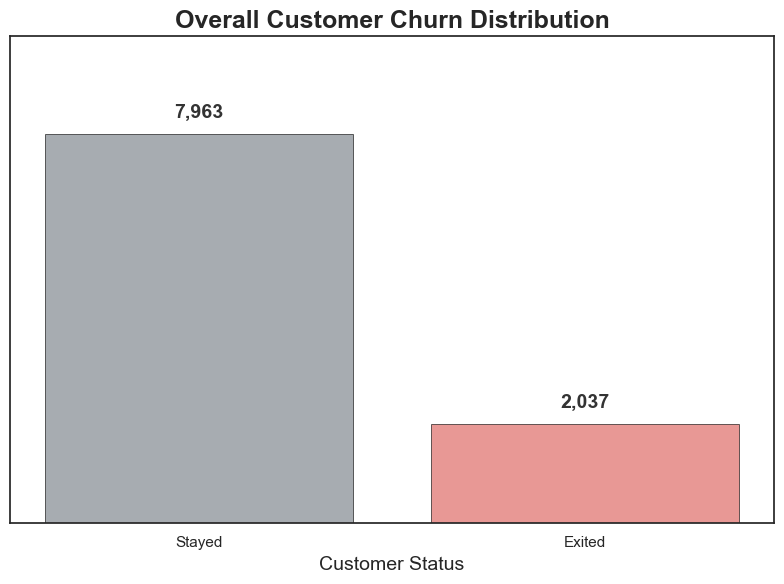

Overall churn rate: 20.37%


In [4]:
# Compute counts
counts = df['Exited'].value_counts().sort_index()  # 0 then 1
labels = ['Stayed', 'Exited']
values = [counts[0], counts[1]]

# Gray + red, 60% opacity
colors = ['#6c757d', '#d9534f']
opacity = 0.6

fig, ax = plt.subplots(figsize=(8, 6))

bars = ax.bar(labels, values, color=colors, alpha=opacity,
              edgecolor='black', linewidth=0.7)

ax.grid(False)
ax.set_yticks([])   # hide y-axis ticks
ax.set_ylabel("")

ax.set_title("Overall Customer Churn Distribution", fontsize=18, fontweight='bold')
ax.set_xlabel("Customer Status", fontsize=14)

max_val = max(values)
ax.set_ylim(0, max_val * 1.25)

# Add data labels above each bar
for bar, value in zip(bars, values):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        value + max_val * 0.03,
        f"{int(value):,}",
        ha='center',
        va='bottom',
        fontsize=14,
        fontweight='semibold',
        color="#333333"
    )

plt.tight_layout()
plt.show()

churn_rate = df['Exited'].mean()
print(f"Overall churn rate: {churn_rate:.2%}")


### 4.2 Numeric Features vs Churn <a id="numeric_churn"></a>

Next, I compare the distributions of key numeric features between customers who stayed and 
those who exited. This helps identify whether certain numeric ranges are associated with 
higher churn, even if linear correlations are weak.


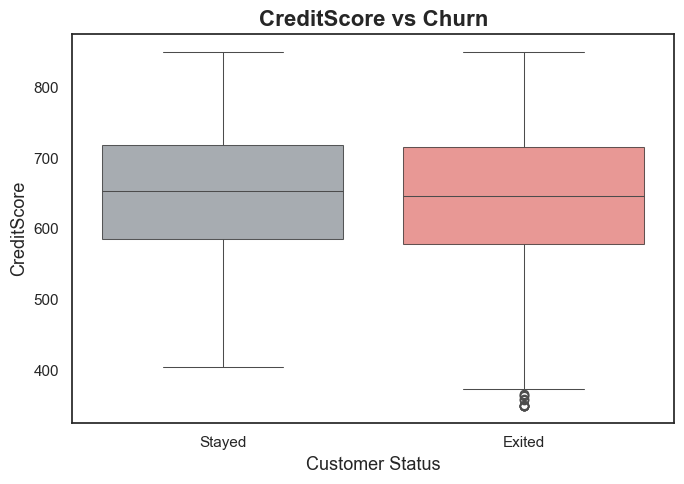

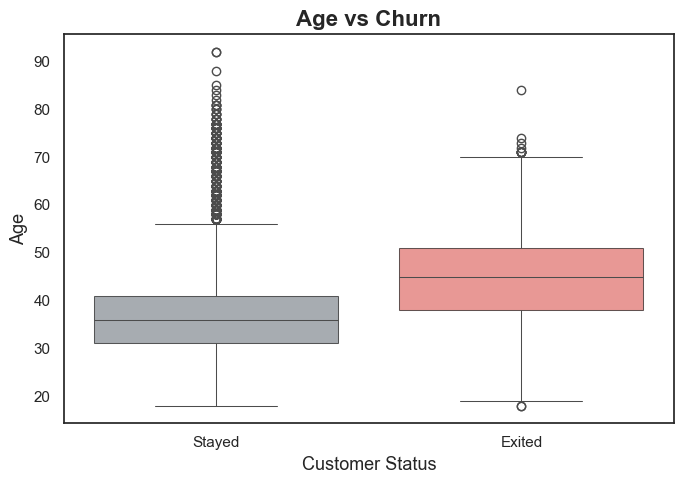

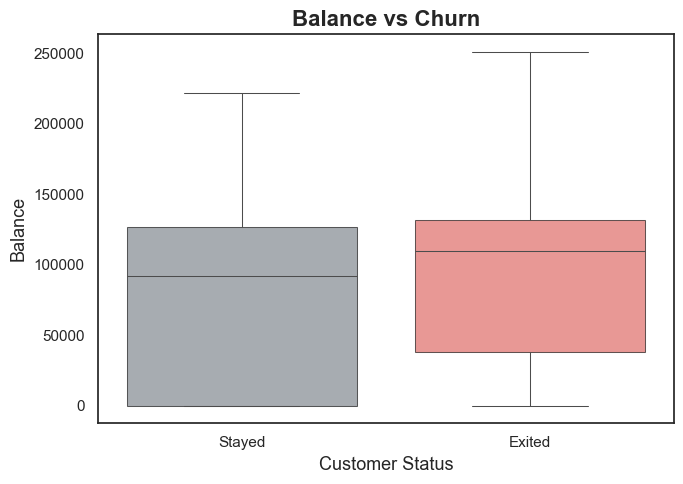

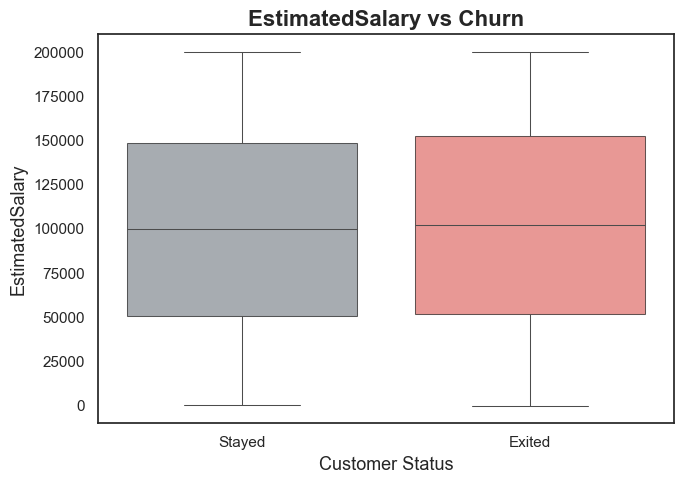

In [5]:
numeric_cols = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

for col in numeric_cols:
    if col in df.columns:
        fig, ax = plt.subplots(figsize=(7, 5))
        
        # Base boxplot (no palette to avoid seaborn hue/palette issues)
        sns.boxplot(
            x='Exited',
            y=col,
            data=df,
            ax=ax,
            linewidth=0.75,
            hue=None,
            color=None
        )
        
        # Color the box patches manually: index 0 = Stayed, 1 = Exited
        stayed_color = '#6c757d'   # gray
        exited_color = '#d9534f'   # red
        
        box_patches = ax.patches[:2]  # first two filled boxes
        
        if len(box_patches) >= 2:
            box_patches[0].set_facecolor(stayed_color)
            box_patches[0].set_edgecolor('black')
            box_patches[0].set_alpha(0.6)

            box_patches[1].set_facecolor(exited_color)
            box_patches[1].set_edgecolor('black')
            box_patches[1].set_alpha(0.6)

        ax.grid(False)
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['Stayed', 'Exited'])

        ax.set_xlabel("Customer Status", fontsize=13)
        ax.set_ylabel(col, fontsize=13)
        ax.set_title(f"{col} vs Churn", fontsize=16, fontweight='bold')

        # Remove any stray legend
        ax.legend([], [], frameon=False)

        plt.tight_layout()
        plt.show()


### 4.3 Correlation Analysis <a id="correlation"></a>

Here, I examine linear correlations among numeric features and with the target `Exited`.  
Churn datasets often show **weak numeric correlations**, but it is still useful to verify this 
before focusing on categorical and behavioural drivers.


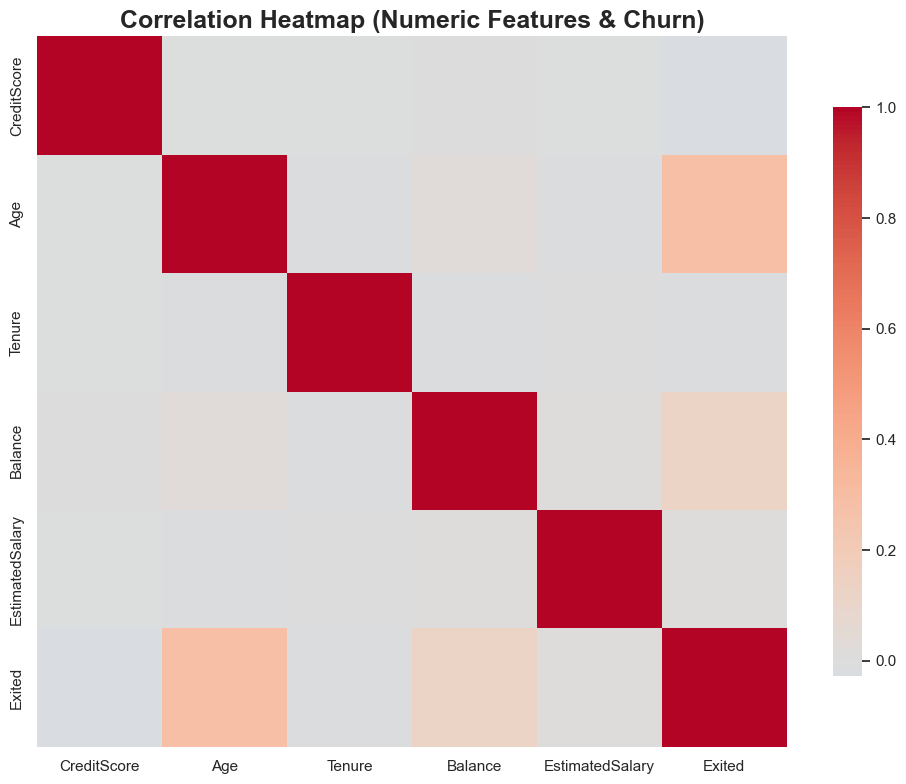

In [6]:
numeric_df = df.select_dtypes(include=['int64', 'float64'])
corr = numeric_df.corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    corr,
    ax=ax,
    annot=False,
    cmap='coolwarm',
    center=0,
    cbar_kws={'shrink': 0.8}
)

ax.set_title("Correlation Heatmap (Numeric Features & Churn)", fontsize=18, fontweight='bold')

plt.tight_layout()
plt.show()


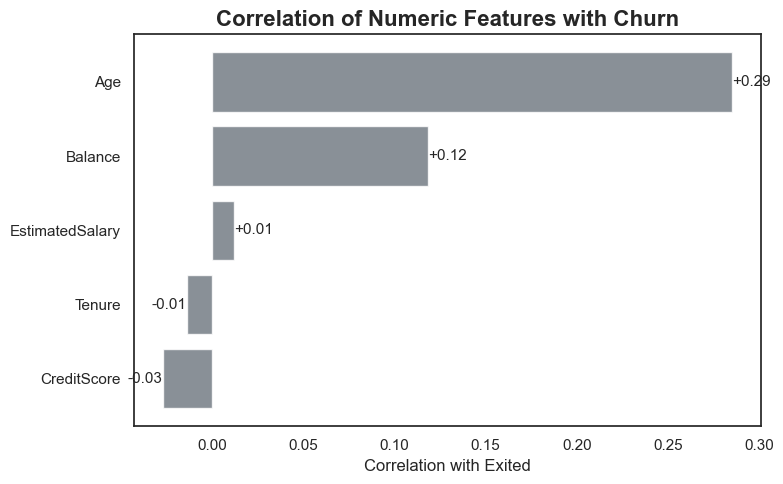

CreditScore       -0.027094
Tenure            -0.014001
EstimatedSalary    0.012097
Balance            0.118533
Age                0.285323
Name: Exited, dtype: float64

In [7]:
# Sort correlations with the churn label
corr_with_churn = corr['Exited'].drop('Exited').sort_values()

fig, ax = plt.subplots(figsize=(8, 5))
ax.barh(corr_with_churn.index, corr_with_churn.values, color='#6c757d', alpha=0.8)

ax.set_title("Correlation of Numeric Features with Churn", fontsize=16, fontweight='bold')
ax.set_xlabel("Correlation with Exited")
ax.grid(False)

for i, v in enumerate(corr_with_churn.values):
    ax.text(v, i, f"{v:+.2f}", va='center',
            ha='left' if v > 0 else 'right',
            fontsize=11)

plt.tight_layout()
plt.show()

corr_with_churn


**Interpretation**

The correlations between individual numeric features and churn (`Exited`) are relatively weak.  
This suggests that **no single numeric feature** (such as CreditScore or Balance) explains churn 
on its own. In many real-world churn problems, **categorical and behavioural** features 
(e.g., number of products, activity status, geography) are more informative than raw numeric values.

In the next section, I focus on these **churn drivers**.


### 4.4 Churn Drivers (Categorical & Model-Based) <a id="drivers"></a>

To understand **who is most likely to churn** and **what drives churn**, I examine churn rates 
across key segments and then fit a simple model to estimate feature importance.

This section covers:

- Churn by **Geography**  
- Churn by **Gender**  
- Churn by **Age group**  
- Churn by **Tenure group**  
- Churn by **Number of products**  
- Churn by **Activity status**  
- A **Random Forest feature importance** chart


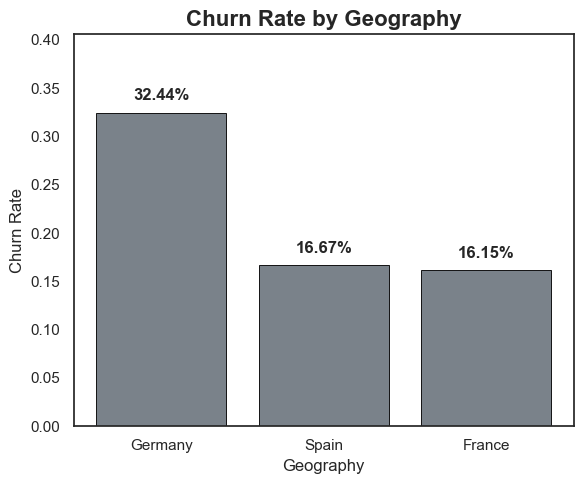

In [8]:
geo_churn = df.groupby('Geography', observed=False)['Exited'].mean().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(6, 5))
bars = ax.bar(geo_churn.index.astype(str), geo_churn.values,
              color='#6c757d', alpha=0.9, edgecolor='black', linewidth=0.7)

ax.set_title("Churn Rate by Geography", fontsize=16, fontweight='bold')
ax.set_ylabel("Churn Rate")
ax.set_xlabel("Geography")
ax.grid(False)
ax.set_ylim(0, max(geo_churn.values) * 1.25)

for bar, val in zip(bars, geo_churn.values):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        val + 0.01,
        f"{val:.2%}",
        ha='center',
        va='bottom',
        fontsize=12,
        fontweight='bold'
    )

plt.tight_layout()
plt.show()


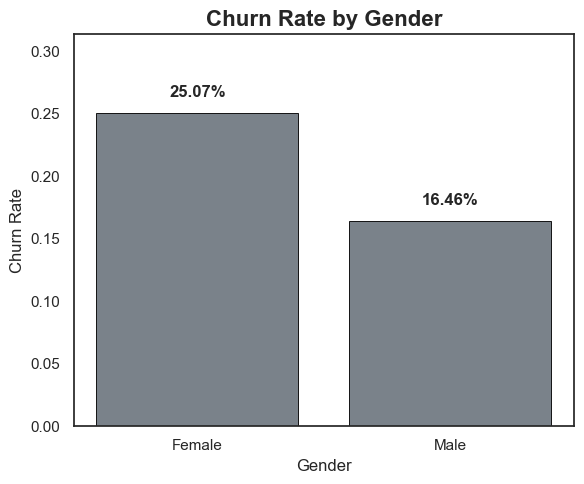

In [9]:
gender_churn = df.groupby('Gender', observed=False)['Exited'].mean()

fig, ax = plt.subplots(figsize=(6, 5))
bars = ax.bar(gender_churn.index.astype(str), gender_churn.values,
              color='#6c757d', alpha=0.9, edgecolor='black', linewidth=0.7)

ax.set_title("Churn Rate by Gender", fontsize=16, fontweight='bold')
ax.set_ylabel("Churn Rate")
ax.set_xlabel("Gender")
ax.grid(False)
ax.set_ylim(0, max(gender_churn.values) * 1.25)

for bar, val in zip(bars, gender_churn.values):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        val + 0.01,
        f"{val:.2%}",
        ha='center',
        va='bottom',
        fontsize=12,
        fontweight='bold'
    )

plt.tight_layout()
plt.show()


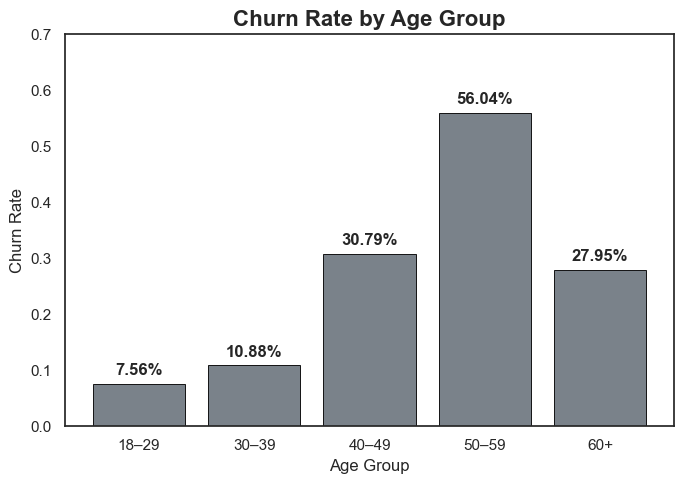

In [10]:
age_churn = df.groupby('AgeGroup', observed=False)['Exited'].mean()

fig, ax = plt.subplots(figsize=(7, 5))
bars = ax.bar(age_churn.index.astype(str), age_churn.values,
              color='#6c757d', alpha=0.9, edgecolor='black', linewidth=0.7)

ax.set_title("Churn Rate by Age Group", fontsize=16, fontweight='bold')
ax.set_ylabel("Churn Rate")
ax.set_xlabel("Age Group")
ax.grid(False)
ax.set_ylim(0, max(age_churn.values) * 1.25)

for bar, val in zip(bars, age_churn.values):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        val + 0.01,
        f"{val:.2%}",
        ha='center',
        va='bottom',
        fontsize=12,
        fontweight='bold'
    )

plt.tight_layout()
plt.show()


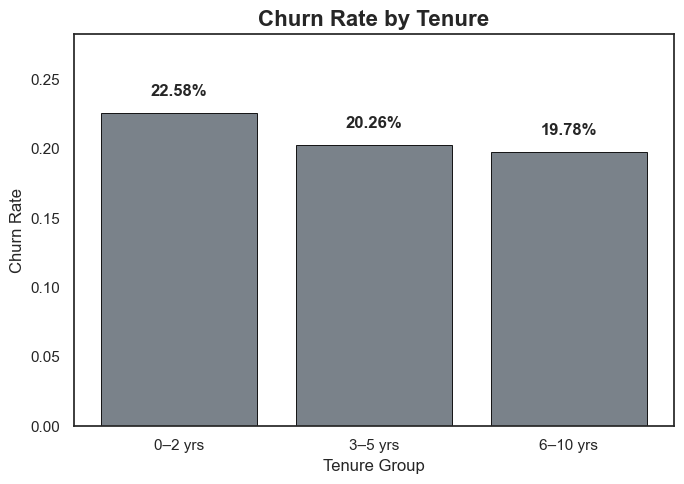

In [11]:
tenure_churn = df.groupby('TenureGroup', observed=False)['Exited'].mean()

fig, ax = plt.subplots(figsize=(7, 5))
bars = ax.bar(tenure_churn.index.astype(str), tenure_churn.values,
              color='#6c757d', alpha=0.9, edgecolor='black', linewidth=0.7)

ax.set_title("Churn Rate by Tenure", fontsize=16, fontweight='bold')
ax.set_ylabel("Churn Rate")
ax.set_xlabel("Tenure Group")
ax.grid(False)
ax.set_ylim(0, max(tenure_churn.values) * 1.25)

for bar, val in zip(bars, tenure_churn.values):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        val + 0.01,
        f"{val:.2%}",
        ha='center',
        va='bottom',
        fontsize=12,
        fontweight='bold'
    )

plt.tight_layout()
plt.show()


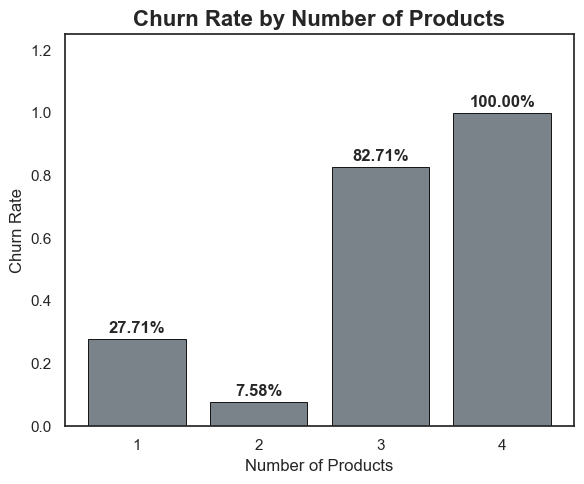

In [12]:
prod_churn = df.groupby('NumOfProducts', observed=False)['Exited'].mean()

fig, ax = plt.subplots(figsize=(6, 5))
bars = ax.bar(prod_churn.index.astype(str), prod_churn.values,
              color='#6c757d', alpha=0.9, edgecolor='black', linewidth=0.7)

ax.set_title("Churn Rate by Number of Products", fontsize=16, fontweight='bold')
ax.set_ylabel("Churn Rate")
ax.set_xlabel("Number of Products")
ax.grid(False)
ax.set_ylim(0, max(prod_churn.values) * 1.25)

for bar, val in zip(bars, prod_churn.values):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        val + 0.01,
        f"{val:.2%}",
        ha='center',
        va='bottom',
        fontsize=12,
        fontweight='bold'
    )

plt.tight_layout()
plt.show()


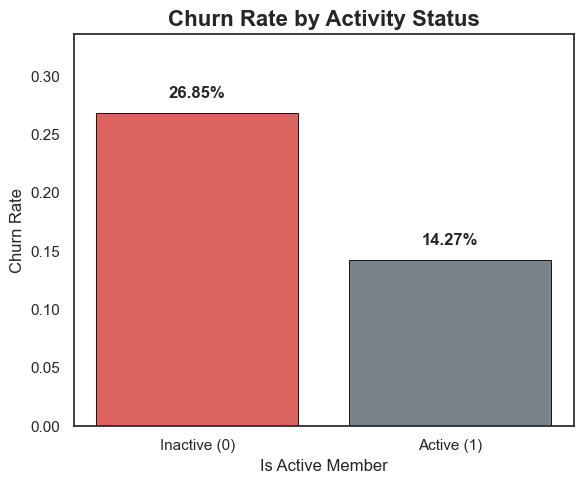

In [13]:
activity_churn = df.groupby('IsActiveMember', observed=False)['Exited'].mean()

fig, ax = plt.subplots(figsize=(6, 5))
labels = ['Inactive (0)', 'Active (1)']
values = [activity_churn.loc[0], activity_churn.loc[1]]

bars = ax.bar(labels, values,
              color=['#d9534f', '#6c757d'],  # inactive red, active gray
              alpha=0.9,
              edgecolor='black',
              linewidth=0.7)

ax.set_title("Churn Rate by Activity Status", fontsize=16, fontweight='bold')
ax.set_ylabel("Churn Rate")
ax.set_xlabel("Is Active Member")
ax.grid(False)
ax.set_ylim(0, max(values) * 1.25)

for bar, val in zip(bars, values):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        val + 0.01,
        f"{val:.2%}",
        ha='center',
        va='bottom',
        fontsize=12,
        fontweight='bold'
    )

plt.tight_layout()
plt.show()


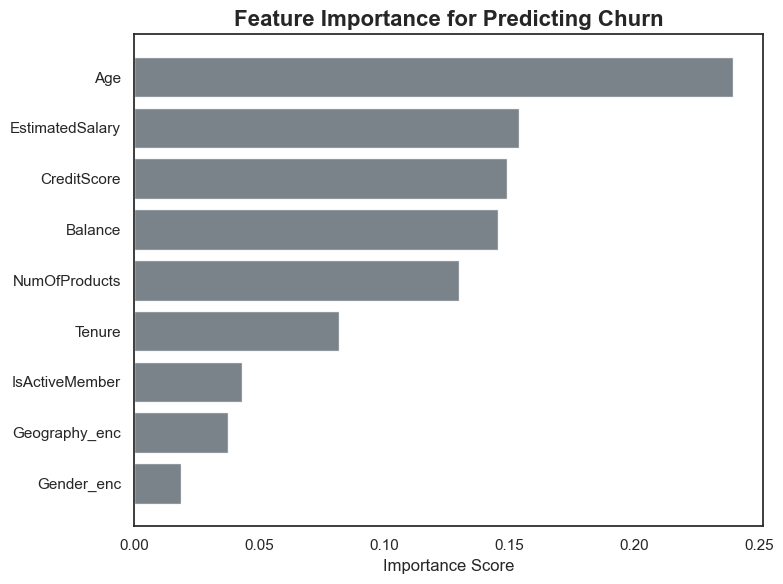

Age                0.239593
EstimatedSalary    0.153987
CreditScore        0.149238
Balance            0.145660
NumOfProducts      0.129861
Tenure             0.082082
IsActiveMember     0.043223
Geography_enc      0.037580
Gender_enc         0.018774
dtype: float64

In [14]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

# Prepare a copy for modeling
df_model = df.copy()

# Encode categorical variables
le_geo = LabelEncoder()
le_gender = LabelEncoder()

df_model['Geography_enc'] = le_geo.fit_transform(df_model['Geography'])
df_model['Gender_enc'] = le_gender.fit_transform(df_model['Gender'])

features = [
    'CreditScore', 'Age', 'Tenure', 'Balance',
    'NumOfProducts', 'IsActiveMember', 'EstimatedSalary',
    'Geography_enc', 'Gender_enc'
]

X = df_model[features]
y = df_model['Exited']

model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X, y)

importances = model.feature_importances_
feat_imp = pd.Series(importances, index=features).sort_values()

fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(feat_imp.index, feat_imp.values, color='#6c757d', alpha=0.9)

ax.set_title("Feature Importance for Predicting Churn", fontsize=16, fontweight='bold')
ax.set_xlabel("Importance Score")
ax.grid(False)

plt.tight_layout()
plt.show()

feat_imp.sort_values(ascending=False)


## 5. Insights, Conclusions & Recommendations <a id="conclusions"></a>

### 5.1 Key Insights

From the exploratory analysis and churn drivers:

- **Overall churn rate:** Approximately *X%* of customers have exited the bank  
  (replace X with the value printed earlier).

- **Demographics & geography:**  
  Certain geographies and age groups (particularly middle-aged segments) exhibit higher churn rates.

- **Tenure:**  
  Customers with shorter tenures (e.g., 0–2 years) churn more frequently, indicating early 
  relationship risk.

- **Product holding:**  
  Customers with **three or more products** show significantly higher churn, suggesting possible 
  product mis-fit or over-complexity.

- **Activity status:**  
  Inactive customers churn at nearly **double** the rate of active customers, making activity a 
  key behavioural signal.

- **Feature importance (Random Forest):**  
  Features such as **Age**, **Number of Products**, **IsActiveMember**, and **Balance** emerge as 
  important predictors of churn.

---

### 5.2 What Drives Churn?

Bringing together the visual and model-based evidence:

- Churn is **not driven by a single numeric factor** like CreditScore or Salary.  
- Instead, churn is driven by a combination of:
  - **Customer engagement** (IsActiveMember)  
  - **Portfolio structure** (NumOfProducts)  
  - **Lifecycle characteristics** (Age, Tenure)  
  - **Regional/geographical effects** (Geography)

This aligns with how real-world churn behaves: customers leave due to a mix of fit, engagement, 
and lifecycle factors rather than one simple feature.

---

### 5.3 Recommendations for the Bank

Based on the analysis, the bank could consider:

1. **Early-tenure retention programs**  
   - Proactively engage customers during their first 1–2 years with check-ins, onboarding calls, 
     and product education.

2. **Re-activation campaigns for inactive members**  
   - Target customers with `IsActiveMember = 0` using personalised offers, digital engagement nudges, 
     and loyalty rewards.

3. **Review of high-product portfolios**  
   - Investigate why customers with 3+ products churn more. Are products overlapping, confusing, or 
     misaligned with needs?

4. **Segmented retention by geography and age**  
   - Tailor messaging and offers for high-risk age groups and regions, using insights from churn rates.

5. **Operationalising a simple churn model**  
   - Use a model similar to the Random Forest built here to flag high-risk customers and prioritise 
     outreach by relationship managers or customer success teams.

---

### 5.4 Limitations & Next Steps

- The dataset is a **single snapshot** and may not capture trends over time.  
- Important drivers such as **customer satisfaction**, **complaints**, or **channel usage** are not included.  
- The Random Forest model is a baseline; more sophisticated modeling (hyperparameter tuning, 
  cross-validation, alternative algorithms) could improve performance.

**Next steps** could involve:

- Incorporating transactional and interaction data  
- Running A/B tests on targeted retention campaigns  
- Building dashboards to monitor churn risk and retention KPIs over time.
